# Load data

In [9]:
import importlib

In [10]:
from tensorflow.keras.datasets import cifar10
import pickle as pkl

#### Download and save data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
with open("train_cifar10.pkl", "wb") as f:
    pkl.dump([x_train, y_train], f)

with open("test_cifar10.pkl", "wb") as f:
    pkl.dump([x_test, y_test], f)

#### Load data downloaded

In [11]:
with open("train_cifar10.pkl", "rb") as f:
    x_train, y_train = pkl.load(f)
    
with open("test_cifar10.pkl", "rb") as f:
    x_test, y_test = pkl.load(f)

# Pre-process data

In [12]:
try:
    importlib.reload(data)
except NameError:
    import data
    
from data import resize_img, crop_img, pca_color_augmentation, norm_preprocessing

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
from PIL import Image

In [14]:
def opencv_to_pil(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    return im_pil

In [15]:
def preprocessing_function(img, augment=True):
    img_padded = cv2.copyMakeBorder(img,top=4,bottom=4,left=4,right=4,borderType=cv2.BORDER_CONSTANT,value=[0, 0, 0])
    img_cropped = crop_img(img_padded, dim_crop=(32,32))
    return img_cropped.astype(np.float32)

#### Convert labels to one-hot encoding

In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
train_generator = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, preprocessing_function=preprocessing_function)
train_generator.fit(x_train)

train_batches = train_generator.flow(x_train, y_train, batch_size=64)

In [18]:
valid_generator = ImageDataGenerator(featurewise_center=True)
valid_generator.fit(x_train)

valid_batches = valid_generator.flow(x_test, y_test, batch_size=64)

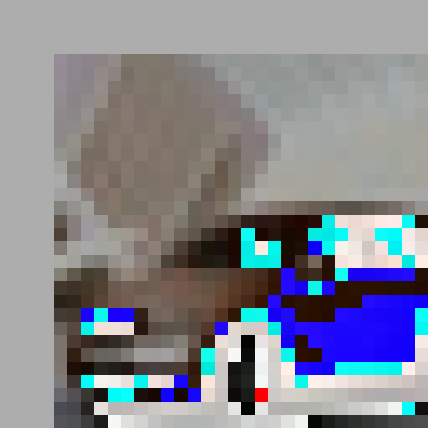

In [19]:
imgs, labels = next(train_batches)
#print(imgs[0])
opencv_to_pil(resize_img(imgs[0].astype(np.uint8)))

# Train network

In [22]:
try:
    importlib.reload(densenet)
except NameError:
    import densenet

from densenet import DenseNetCIFAR

In [27]:
densenet_cifar = DenseNetCIFAR()
densenet_cifar.create_model(k = 12, L=100)

In [28]:
densenet_cifar.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 24)   3552        input_3[0][0]                    
__________________________________________________________________________________________________
bottleneck_bn_block_1_0 (BatchN (None, 16, 16, 24)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
bottleneck_relu_block_1_0 (Acti (None, 16, 16, 24)   0           bottleneck_bn_block_1_0[0][0]    
____________________________________________________________________________________________

In [ ]:
densenet_cifar.train_model(train_batches, valid_batches)

In [19]:
densenet_cifar.save_model('densenet.h5')

In [ ]:
densenet_cifar = DenseNetCIFAR.load_model('densenet.h5')